In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### 读取数据

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
Xtrain = pd.read_csv('X_train.csv')
Xtest = pd.read_csv('X_test.csv')
ytrain = pd.read_csv('y_train.csv')
ytest = pd.read_csv('y_test.csv')

### 特征工程

In [4]:
for feature in list(Xtrain.columns):
    if Xtrain[feature].count() < 5000:
        del Xtrain[feature]
        del Xtest[feature]

In [5]:
X = pd.concat([Xtrain, Xtest], axis=0)
y = pd.concat([ytrain, ytest], axis=0)

In [6]:
X = X.reset_index(drop = True) #合并后序号重新排列

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9032 entries, 0 to 9031
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_frame_rate          9032 non-null   object 
 1   bit_rate                9004 non-null   float64
 2   channel_layout          9004 non-null   object 
 3   channels                9004 non-null   float64
 4   codec_long_name         9032 non-null   object 
 5   codec_long_name.1       9004 non-null   object 
 6   codec_name              9004 non-null   object 
 7   codec_name.1            9032 non-null   object 
 8   codec_tag               9032 non-null   object 
 9   codec_tag_string        9032 non-null   object 
 10  coded_height            9032 non-null   int64  
 11  coded_width             9032 non-null   int64  
 12  color_primaries         6062 non-null   object 
 13  color_range             6499 non-null   object 
 14  color_space             6335 non-null   

In [8]:
for feature in list(X.columns):
    if X[feature].isnull().sum() > 0:
        X[feature] = X[feature].fillna(method='ffill')
    else:
        pass

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9032 entries, 0 to 9031
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_frame_rate          9032 non-null   object 
 1   bit_rate                9032 non-null   float64
 2   channel_layout          9032 non-null   object 
 3   channels                9032 non-null   float64
 4   codec_long_name         9032 non-null   object 
 5   codec_long_name.1       9032 non-null   object 
 6   codec_name              9032 non-null   object 
 7   codec_name.1            9032 non-null   object 
 8   codec_tag               9032 non-null   object 
 9   codec_tag_string        9032 non-null   object 
 10  coded_height            9032 non-null   int64  
 11  coded_width             9032 non-null   int64  
 12  color_primaries         9032 non-null   object 
 13  color_range             9032 non-null   object 
 14  color_space             9032 non-null   

In [10]:
# X = X.dropna(axis=1)  #丢失含有缺失值的特征

In [11]:
for feature in list(X.columns):
    if X[feature].dtype == 'object':
        x = X[feature].values.reshape(-1,1)
        encode = OneHotEncoder(categories='auto').fit_transform(x).toarray()
        del X[feature]
        X = pd.concat([X, pd.DataFrame(encode)], axis=1)
        assert len(X) == 9032
    else:
        pass

In [12]:
std_transform = MinMaxScaler()
X = std_transform.fit_transform(X)

### 特征选择

In [13]:
pca = PCA(n_components=100)
X = pca.fit_transform(X)

In [14]:
Xtrain = pd.DataFrame(X).iloc[0:len(Xtrain),:]
Xtest = pd.DataFrame(X).iloc[len(Xtrain):,:]

### 随机森林分类

In [15]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=0, oob_score=True)

In [16]:
rfc = rfc.fit(Xtrain,ytrain)

<ipython-input-16-ba21a1a54e75>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = rfc.fit(Xtrain,ytrain)


In [17]:
rfc_pred = rfc.predict(Xtest)

### 随机森林分类结果打印与可视化

In [18]:
rfc_accuracy = accuracy_score(ytest, rfc_pred)
rfc_recall = recall_score(ytest, rfc_pred, average='macro')
rfc_f1 = f1_score(ytest, rfc_pred, average='macro')
print('accuracy :',rfc_accuracy)
print('recall :',rfc_recall)
print('f1 score :',rfc_f1)
print('all claasification_report :\n ',classification_report(ytest, rfc_pred))

accuracy : 0.9557522123893806
recall : 0.9541914934077079
f1 score : 0.9535952625788182
all claasification_report :
                precision    recall  f1-score   support

           0       0.84      0.91      0.87       102
           1       1.00      1.00      1.00        88
           2       0.99      1.00      1.00       112
           3       0.99      0.97      0.98       116
           4       0.99      1.00      1.00       104
           5       0.87      0.85      0.86       100
           6       1.00      1.00      1.00       154
           7       0.95      0.91      0.93       128

    accuracy                           0.96       904
   macro avg       0.95      0.95      0.95       904
weighted avg       0.96      0.96      0.96       904



In [19]:
cm = confusion_matrix(ytest.values.squeeze(), rfc_pred)

Text(0.5, 1.0, '混淆矩阵')

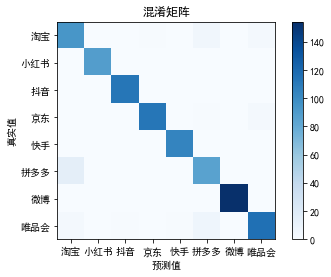

In [20]:
plt.imshow(cm, cmap=plt.cm.Blues)
indices = range(len(cm))
plt.xticks(indices, ['淘宝','小红书','抖音','京东','快手','拼多多','微博','唯品会'])
plt.yticks(indices, ['淘宝','小红书','抖音','京东','快手','拼多多','微博','唯品会'])
plt.colorbar()
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.title('混淆矩阵')

### Adaboost分类

In [21]:
base_estimator = DecisionTreeClassifier(max_depth=4, min_samples_split=20, min_samples_leaf=5)

In [22]:
bdt = AdaBoostClassifier(base_estimator,
                         algorithm="SAMME",
                         n_estimators=100, learning_rate=0.8)

In [23]:
bdt.fit(Xtrain, ytrain)

D:\python3_6\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=4,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20),
                   learning_rate=0.8, n_estimators=100)

In [24]:
bdt_pred = bdt.predict(Xtest)

### adaboost分类结果打印与可视化

In [25]:
bdt_accuracy = accuracy_score(ytest, bdt_pred)
bdt_recall = recall_score(ytest, bdt_pred, average='macro')
bdt_f1 = f1_score(ytest, bdt_pred, average='macro')
print('accuracy :',bdt_accuracy)
print('recall :',bdt_recall)
print('f1 score :',bdt_f1)
print('all claasification_report :\n ',classification_report(ytest, bdt_pred))

accuracy : 0.9391592920353983
recall : 0.9358026174246223
f1 score : 0.935951623081118
all claasification_report :
                precision    recall  f1-score   support

           0       0.83      0.78      0.81       102
           1       1.00      1.00      1.00        88
           2       0.99      0.98      0.99       112
           3       0.98      0.97      0.97       116
           4       1.00      0.99      1.00       104
           5       0.78      0.85      0.81       100
           6       1.00      1.00      1.00       154
           7       0.91      0.91      0.91       128

    accuracy                           0.94       904
   macro avg       0.94      0.94      0.94       904
weighted avg       0.94      0.94      0.94       904



In [26]:
cm = confusion_matrix(ytest.values.squeeze(), bdt_pred)

Text(0.5, 1.0, '混淆矩阵')

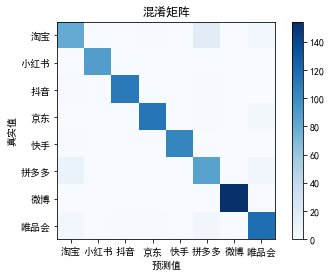

In [27]:
plt.imshow(cm, cmap=plt.cm.Blues)
indices = range(len(cm))
plt.xticks(indices, ['淘宝','小红书','抖音','京东','快手','拼多多','微博','唯品会'])
plt.yticks(indices, ['淘宝','小红书','抖音','京东','快手','拼多多','微博','唯品会'])
plt.colorbar()
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.title('混淆矩阵')

### 神经网络分类

In [28]:
Xtrain = torch.from_numpy(Xtrain.values).type(torch.FloatTensor)
Xtest = torch.from_numpy(Xtest.values).type(torch.FloatTensor)
ytrain = torch.from_numpy(ytrain.values).type(torch.LongTensor)
ytest = torch.from_numpy(ytest.values).type(torch.LongTensor)

In [29]:
Xtrain.size(), Xtest.size(), ytrain.size(), ytest.size()

(torch.Size([8128, 100]),
 torch.Size([904, 100]),
 torch.Size([8128, 1]),
 torch.Size([904, 1]))

In [30]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(100, 1024)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 256)
        self.linear_4 = nn.Linear(256,128)
        self.linear_5 = nn.Linear(128, 64)
        self.linear_6 = nn.Linear(64, 32)
        self.linear_7 = nn.Linear(32, 8)
        self.relu = nn.ReLU()
    def forward(self, input):
        x1 = self.linear_1(input)
        x1 = self.relu(x1)
        x2 = self.linear_2(x1)
        x2 = self.relu(x2)
        x3 = self.linear_3(x2)
        x3 = self.relu(x3)
        x4 = self.linear_4(x3)
        x4 = self.relu(x4)
        x5 = self.linear_5(x4)
        x5 = self.relu(x5)
        x6 = self.linear_6(x5)
        x6 = self.relu(x6)
        x7 = self.linear_7(x6)
        return x7

In [31]:
model = Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0001

In [32]:
def get_model():
    model = Model()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    return model, opt

In [33]:
model, opt = get_model()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32
number_of_batch = len(Xtrain)//batch_size

In [34]:
train_ds = TensorDataset(Xtrain, ytrain) 
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [35]:
test_ds = TensorDataset(Xtest, ytest) 
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [36]:
# 训练函数
def train(dl, model, loss_fn, optimizer):
    size = len(dl.dataset)    
    num_batches = len(dl)
        
    train_loss, correct = 0, 0
        
    for x, y in dl:
        x, y = x.to(device), y.squeeze(dim=1).to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches
    return correct, train_loss

In [37]:
# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset)    
    num_batches = len(test_dl)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.squeeze(dim=1).to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= size
        test_loss /= num_batches
        return correct, test_loss

In [38]:
epochs = 20

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_acc, epoch_loss = train(train_dl, model, loss_fn, opt)
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.1f},test_Loss:{:.5f}, test_acc:{:.1f}")
    
    print(template.format(epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
print('Done')

epoch: 0, train_Loss:1.30511, train_acc:56.8,test_Loss:0.40254, test_acc:88.4
epoch: 1, train_Loss:0.27216, train_acc:91.4,test_Loss:0.21746, test_acc:93.1
epoch: 2, train_Loss:0.19789, train_acc:93.9,test_Loss:0.18839, test_acc:94.0
epoch: 3, train_Loss:0.16880, train_acc:94.7,test_Loss:0.17762, test_acc:94.1
epoch: 4, train_Loss:0.15054, train_acc:95.0,test_Loss:0.16449, test_acc:94.8
epoch: 5, train_Loss:0.14081, train_acc:95.2,test_Loss:0.15441, test_acc:95.0
epoch: 6, train_Loss:0.13352, train_acc:95.3,test_Loss:0.16934, test_acc:94.4
epoch: 7, train_Loss:0.12628, train_acc:95.7,test_Loss:0.16004, test_acc:94.5
epoch: 8, train_Loss:0.12093, train_acc:95.7,test_Loss:0.16538, test_acc:94.7
epoch: 9, train_Loss:0.11355, train_acc:96.0,test_Loss:0.15536, test_acc:94.9
epoch:10, train_Loss:0.10897, train_acc:95.8,test_Loss:0.16288, test_acc:95.6
epoch:11, train_Loss:0.10682, train_acc:96.0,test_Loss:0.17397, test_acc:95.2
epoch:12, train_Loss:0.10335, train_acc:96.2,test_Loss:0.15145, 

### 训练过程可视化

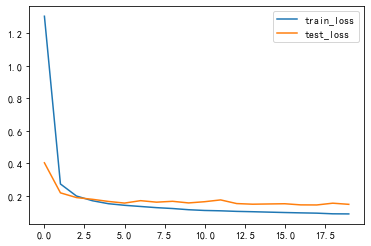

In [39]:
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

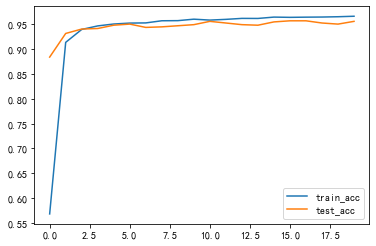

In [40]:
plt.plot(range(epochs), train_acc, label='train_acc')
plt.plot(range(epochs), test_acc, label='test_acc')
plt.legend()

### 神经网络分类结果打印与可视化

In [41]:
def evaluate(test_dl, model):
    size = len(test_dl.dataset)    
    num_batches = len(test_dl)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.squeeze(dim=1).to(device)
            pred = model(x)
            pred = torch.argmax(pred, dim=1)
            net_accuracy = accuracy_score(y.cpu(), pred.cpu())
            net_recall = recall_score(y.cpu(), pred.cpu(),  average='macro')
            net_f1 = f1_score(y.cpu(), pred.cpu(),  average='macro')
            print('accuracy : ',net_accuracy)
            print('recall : ',net_recall)
            print('f1 score : ',net_f1)
            print('all claasification_report :\n ',classification_report(pred.cpu(), y.cpu()))
            return net_accuracy, net_recall, net_f1

In [42]:
test_ds = TensorDataset(Xtest, ytest) 
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=True)

In [43]:
net_accuracy, net_recall, net_f1 = evaluate(test_dl, model)

accuracy :  0.9557522123893806
recall :  0.9531734121450304
f1 score :  0.9531442147290194
all claasification_report :
                precision    recall  f1-score   support

           0       0.85      0.87      0.86       100
           1       1.00      1.00      1.00        88
           2       1.00      0.99      1.00       113
           3       0.98      0.96      0.97       119
           4       1.00      0.99      1.00       105
           5       0.86      0.89      0.87        97
           6       1.00      1.00      1.00       154
           7       0.93      0.93      0.93       128

    accuracy                           0.96       904
   macro avg       0.95      0.95      0.95       904
weighted avg       0.96      0.96      0.96       904



In [44]:
size = len(test_dl.dataset)    
num_batches = len(test_dl)
test_loss, correct = 0, 0
with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.squeeze(dim=1).to(device)
        pred = model(x)
        pred = torch.argmax(pred, dim=1)
        cm = confusion_matrix(y.cpu().numpy(),pred.cpu().numpy()) 

Text(0.5, 1.0, '混淆矩阵')

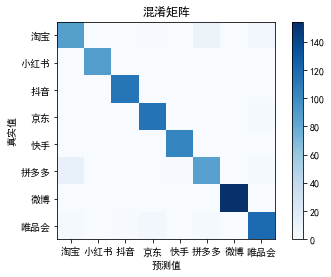

In [45]:
plt.imshow(cm, cmap=plt.cm.Blues)
indices = range(len(cm))
plt.xticks(indices, ['淘宝','小红书','抖音','京东','快手','拼多多','微博','唯品会'])
plt.yticks(indices, ['淘宝','小红书','抖音','京东','快手','拼多多','微博','唯品会'])
plt.colorbar()
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.title('混淆矩阵')